# Overview 🔎  
  
This notebook demonstrates the use of a multi-agent system for collaborative research using the AutoGen library. The system leverages multiple agents to interact and solve tasks collaboratively, focusing on efficient task execution and quality assurance.  
  
## Motivation  
  
Multi-agent systems can enhance collaborative research by distributing tasks among specialized agents. This approach aims to demonstrate how agents with distinct roles can work together to achieve complex objectives.  
  
## Key Components  
  
- **AutoGen Library**: Facilitates the creation and management of multi-agent interactions.  
- **Agents**: Include a human admin, AI developer, planner, executor, and quality assurance agent, each with specific responsibilities.  
- **Group Chat**: Manages the conversation flow and context among agents.  
  
## Method  
  
The system follows a structured approach:  
  
1. **Agent Configuration**: Each agent is set up with a specific role, behavior, and configuration using the GPT-4 model.  
     
2. **Role Assignment**:  
   - **Admin**: Approves plans and provides guidance.  
   - **Developer**: Writes code based on approved plans.  
   - **Planner**: Develops detailed plans for task execution.  
   - **Executor**: Executes the code written by the developer.  
   - **Quality Assurance**: Ensures the plan and execution meet quality standards.  
  
3. **Interaction Management**:  
   - **Allowed Transitions**: Defines permissible interactions between agents to maintain orderly communication.  
   - **Graph Representation**: Visualizes agent interactions to clarify relationships and transitions.  
  
4. **Task Execution**: The admin initiates a task, and agents collaboratively work through planning, coding, executing, and quality checking.  
  
## Conclusion  
  
This notebook illustrates a robust framework for collaborative research using a multi-agent system. By distributing tasks among specialized agents and managing interactions effectively, it demonstrates a scalable approach to solving complex research tasks. This system can be adapted to various domains, enhancing collaboration and efficiency.  


# Build your dream team: Perform Research with Multi-Agent Group Chat

AutoGen provides a general conversation pattern called group chat, which involves more than two agents. The core idea of group chat is that all agents contribute to a single conversation thread and share the same context. This is useful for tasks that require collaboration among multiple agents.
This is a sample notebook, you can check a comprehensive solution with UI here:
https://github.com/yanivvak/dream-team

## Requirements

AutoGen requires `Python>=3.8`

Docker - to execute code you need a running docker, you can read more [here](https://microsoft.github.io/autogen/blog/2024/01/23/Code-execution-in-docker/)

In [ ]:
%pip install autogen matplotlib

## Set your API Endpoint

You can load a list of configurations from an environment variable or a json file.

In [4]:
from autogen.agentchat import UserProxyAgent,AssistantAgent,GroupChat,GroupChatManager
import os
from dotenv import load_dotenv
load_dotenv()
config_list_gpt4 = [
  {
    "model": "gpt-4o",
    "api_type": "azure",
    "api_key": os.getenv('AZURE_OPENAI_KEY'),
    "base_url": os.getenv('AZURE_OAI_ENDPOINT'),
    "api_version": "2024-06-01"
  },
  ]

#if you are uisng openai api key, use the below config:
#config_list_gpt4 = [{"model": "gpt-4o", "api_key": os.getenv('OPENAI_API_KEY')}]

In [5]:
gpt4_config = {
    "cache_seed": 42,  # change the cache_seed for different trials
    "temperature": 0,
    "config_list": config_list_gpt4,
    "timeout": 120,
}

## Construct Agents

Let's build our team, this code is setting up a system of agents using the autogen library. The agents include a human admin, an AI Developer, a scientist, a planner, an executor, and a quality assurance agent. Each agent is configured with a name, a role, and specific behaviors or responsibilities.

In [7]:
# User Proxy Agent  
user_proxy = UserProxyAgent(  
    name="Admin",  
    human_input_mode="ALWAYS",  
    system_message="1. A human admin. 2. Interact with the team. 3. Plan execution needs to be approved by this Admin.",  
    code_execution_config=False,  
    llm_config=gpt4_config,  
    description="""Call this Agent if:   
        You need guidance.
        The program is not working as expected.
        You need api key                  
        DO NOT CALL THIS AGENT IF:  
        You need to execute the code.""",  
)  
  
# Assistant Agent - Developer  
developer = AssistantAgent(  
    name="Developer",  
    llm_config=gpt4_config,  
    system_message="""You are an AI developer. You follow an approved plan, follow these guidelines: 
    1. You write python/shell code to solve tasks. 
    2. Wrap the code in a code block that specifies the script type.   
    3. The user can't modify your code. So do not suggest incomplete code which requires others to modify.   
    4. You should print the specific code you would like the executor to run.
    5. Don't include multiple code blocks in one response.   
    6. If you need to import libraries, use ```bash pip install module_name```, please send a code block that installs these libraries and then send the script with the full implementation code 
    7. Check the execution result returned by the executor,  If the result indicates there is an error, fix the error and output the code again  
    8. Do not show appreciation in your responses, say only what is necessary.    
    9. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
    """,  
    description="""Call this Agent if:   
        You need to write code.                  
        DO NOT CALL THIS AGENT IF:  
        You need to execute the code.""",  
)  
# Assistant Agent - Planner  
planner = AssistantAgent(  
    name="Planner",  #2. The research should be executed with code
    system_message="""You are an AI Planner,  follow these guidelines: 
    1. Your plan should include 5 steps, you should provide a detailed plan to solve the task.
    2. Post project review isn't needed. 
    3. Revise the plan based on feedback from admin and quality_assurance.   
    4. The plan should include the various team members,  explain which step is performed by whom, for instance: the Developer should write code, the Executor should execute code, important do not include the admin in the tasks e.g ask the admin to research.  
    5. Do not show appreciation in your responses, say only what is necessary.  
    6. The final message should include an accurate answer to the user request
    """,  
    llm_config=gpt4_config,  
    description="""Call this Agent if:   
        You need to build a plan.                  
        DO NOT CALL THIS AGENT IF:  
        You need to execute the code.""",  
)  
  
# User Proxy Agent - Executor  
executor = UserProxyAgent(  
    name="Executor",  
    system_message="1. You are the code executer. 2. Execute the code written by the developer and report the result.3. you should read the developer request and execute the required code",  
    human_input_mode="NEVER",  
    code_execution_config={  
        "last_n_messages": 20,  
        "work_dir": "dream",  
        "use_docker": True,  
    },  
    description="""Call this Agent if:   
        You need to execute the code written by the developer.  
        You need to execute the last script.  
        You have an import issue.  
        DO NOT CALL THIS AGENT IF:  
        You need to modify code""",
)
quality_assurance = AssistantAgent(
    name="Quality_assurance",
    system_message="""You are an AI Quality Assurance. Follow these instructions:
      1. Double check the plan, 
      2. if there's a bug or error suggest a resolution
      3. If the task is not solved, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach.""",
    llm_config=gpt4_config,
)

Group chat is a powerful conversation pattern, but it can be hard to control if the number of participating agents is large. AutoGen provides a way to constrain the selection of the next speaker by using the allowed_or_disallowed_speaker_transitions argument of the GroupChat class.

In [8]:
allowed_transitions = {
    user_proxy: [ planner,quality_assurance],
    planner: [ user_proxy, developer, quality_assurance],
    developer: [executor,quality_assurance, user_proxy],
    executor: [developer],
    quality_assurance: [planner,developer,executor,user_proxy],
}

In [9]:
system_message_manager="You are the manager of a research group your role is to manage the team and make sure the project is completed successfully."
groupchat = GroupChat(
    agents=[user_proxy, developer, planner, executor, quality_assurance],allowed_or_disallowed_speaker_transitions=allowed_transitions,
    speaker_transitions_type="allowed", messages=[], max_round=30,send_introductions=True
)
manager = GroupChatManager(groupchat=groupchat, llm_config=gpt4_config, system_message=system_message_manager)

Sometimes it's a bit complicated to understand the relationship between the entities, here we print a graph representation of the code


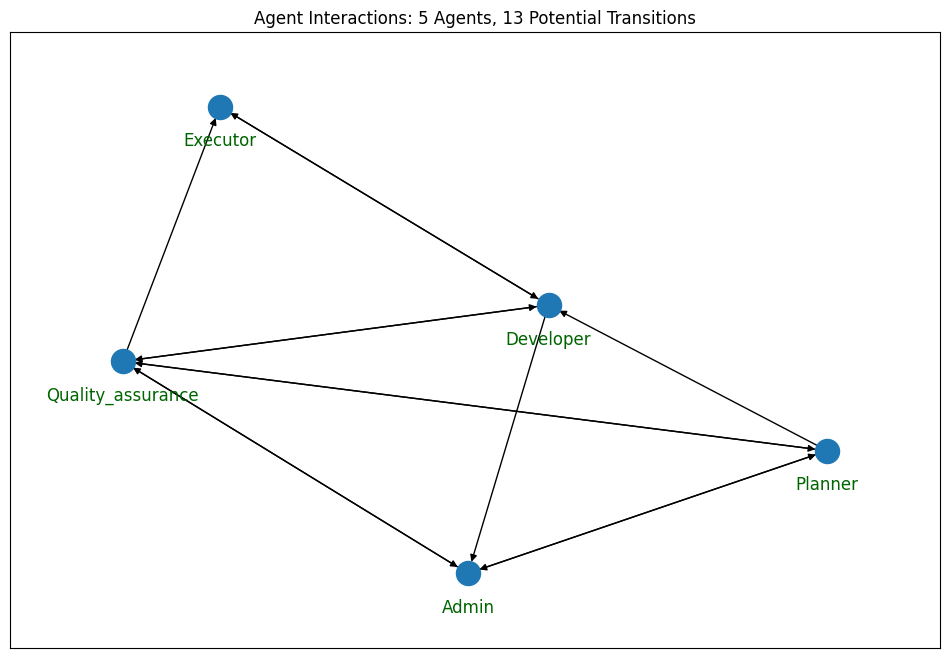

In [10]:
    
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes
G.add_nodes_from([agent.name for agent in groupchat.agents])

# Add edges
for key, value in allowed_transitions.items():
    for agent in value:
        G.add_edge(key.name, agent.name)

# Set the figure size
plt.figure(figsize=(12, 8))

# Visualize
pos = nx.spring_layout(G)  # For consistent positioning

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

# Draw labels below the nodes
label_pos = {k: [v[0], v[1] - 0.1] for k, v in pos.items()}  # Shift labels below the nodes
nx.draw_networkx_labels(G, label_pos, verticalalignment='top', font_color="darkgreen")

# Adding margins
ax = plt.gca()
ax.margins(0.1)  # Increase the margin value if needed


# Adding a dynamic title
total_transitions = sum(len(v) for v in allowed_transitions.values())
title = f'Agent Interactions: {len(groupchat.agents)} Agents, {total_transitions} Potential Transitions'
plt.title(title)

plt.show()

## Start Chat

In [ ]:
task1="what are the 5 leading GitHub repositories on llm for the legal domain?"
chat_result=user_proxy.initiate_chat(
    manager,
    message=task1
, clear_history=True
)

Quality_assurance (to chat_manager):

### Final List of 5 Leading GitHub Repositories on LLM for the Legal Domain

1. **Repository Name:** [lexpredict-lexnlp](https://github.com/LexPredict/lexpredict-lexnlp)
   - **Description:** LexNLP by LexPredict
   - **Stars:** 676
   - **Forks:** 174

2. **Repository Name:** [Blackstone](https://github.com/ICLRandD/Blackstone)
   - **Description:** A spaCy pipeline and model for NLP on unstructured legal text.
   - **Stars:** 632
   - **Forks:** 100

3. **Repository Name:** [Legal-Text-Analytics](https://github.com/Liquid-Legal-Institute/Legal-Text-Analytics)
   - **Description:** A list of selected resources, methods, and tools dedicated to Legal Text Analytics.
   - **Stars:** 563
   - **Forks:** 113

4. **Repository Name:** [2019Legal-AI-Challenge-Legal-Case-Element-Recognition-solution](https://github.com/wangxupeng/2019Legal-AI-Challenge-Legal-Case-Element-Recognition-solution)
   - **Description:** Completed this competition in collaboration with Jiang Yan and Guan Shuicheng.
   - **Stars:** 501
   - **Forks:** 33

5. **Repository Name:** [DISC-LawLLM](https://github.com/FudanDISC/DISC-LawLLM)
   - **Description:** DISC-LawLLM, an intelligent legal system utilizing large language models (LLMs) to provide a wide range of legal services.
   - **Stars:** 445
   - **Forks:** 45

### Verification and Finalization

**Quality Assurance Task:**
- **Double-check the final list:** Ensure that the repositories meet all the criteria and are indeed leading repositories in the legal domain.
- **Provide a brief description:** Each repository has been described briefly, highlighting its relevance to the legal domain.

The task is now complete, and the final list of leading GitHub repositories on LLM for the legal domain has been verified and finalized.

In [ ]:
task2="based on techcrunch, please find 3 articles on companies developing llm for legal domain, that rasied seed round. please use serper api"
chat_result=user_proxy.initiate_chat(
    manager,
    message=task2
, clear_history=False
)

Quality_assurance (to chat_manager):

### Final Markdown Table of 3 Articles on Companies Developing LLM for Legal Domain that Raised Seed Round

```markdown
| Rank | Title | Link | Description |
|------|-------|------|-------------|
| 1    | [Credal aims to connect company data to LLMs 'securely'](https://techcrunch.com/2023/10/26/credal-aims-to-connect-company-data-to-llms-securely/) | Credal.ai, a startup building a platform to connect company data sources to LLMs, has raised new capital in a seed round. |
| 2    | [Lakera launches to protect large language models from ...](https://techcrunch.com/2023/10/12/lakera-launches-to-protect-large-language-models-from-malicious-prompts/) | Lakera launches with the promise to protect enterprises from LLM security weaknesses including prompt injections. |
| 3    | [Deasie wants to rank and filter data to make generative AI ...](https://techcrunch.com/2023/10/12/deasie-wants-to-rank-and-filter-data-to-make-generative-ai-more-reliable/) | Deasie, a startup building a platform that auto-classifies and ranks data to make LLMs more reliable (ostensibly), has raised $2.9 million ... |
```

### Verification and Finalization

**Quality Assurance Task:**
- **Double-check the final list:** Ensure that the articles meet all the criteria and are indeed relevant articles in the legal domain.
- **Provide a brief description:** Each article has been described briefly, highlighting its relevance to the legal domain.

The task is now complete, and the final markdown table of the 3 most relevant articles on companies developing LLM for the legal domain that have raised a seed round has been verified and finalized.


In [14]:
import pprint
pprint.pprint(chat_result.cost)
#pprint.pprint(chat_result.summary)
#pprint.pprint(chat_result.chat_history)

{'usage_excluding_cached_inference': {'gpt-4o-2024-08-06': {'completion_tokens': 155,
                                                            'cost': 0,
                                                            'prompt_tokens': 6796,
                                                            'total_tokens': 6951},
                                      'total_cost': 0},
 'usage_including_cached_inference': {'gpt-4o-2024-08-06': {'completion_tokens': 155,
                                                            'cost': 0,
                                                            'prompt_tokens': 6796,
                                                            'total_tokens': 6951},
                                      'total_cost': 0}}


You can reset the agents:

In [ ]:
for agent in groupchat.agents:
    agent.reset()